In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalAveragePooling1D, Add, Activation # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'../../Dataset/NCA Preprocessed/master_features_nca.csv')
df

,filename,cell_id,temp,charge_rate,discharge_rate,cycle,SOH,IC_bin_1,IC_bin_2,IC_bin_3,...,IC_bin_11,IC_bin_12,IC_bin_13,IC_bin_14,IC_bin_15,IC_bin_16,IC_bin_17,IC_bin_18,IC_bin_19,IC_bin_20
0,CY25-025_1-#1.csv,1,25,0.25,1.0,1,99.96,3.206253,3.435524,3.772510,...,4.255246,4.207070,4.229390,4.248806,4.264151,4.198406,4.058616,3.920543,3.792856,3.647914
1,CY25-025_1-#1.csv,1,25,0.25,1.0,2,99.98,3.185611,3.409977,3.737496,...,4.249921,4.223132,4.181276,4.225006,4.231327,4.158785,4.055173,3.905594,3.737473,3.648392
2,CY25-025_1-#1.csv,1,25,0.25,1.0,3,100.00,3.166235,3.397673,3.713245,...,4.235653,4.189766,4.140167,4.167926,4.180849,4.145106,4.015124,3.896722,3.756668,3.646670
3,CY25-025_1-#1.csv,1,25,0.25,1.0,4,99.97,3.139468,3.376350,3.683448,...,4.254307,4.162355,4.134256,4.143371,4.135573,4.118733,4.023064,3.867330,3.752034,3.631178
4,CY25-025_1-#1.csv,1,25,0.25,1.0,5,99.93,3.132129,3.346752,3.653736,...,4.216513,4.164974,4.094929,4.101335,4.135343,4.100581,4.008745,3.881142,3.761407,3.626212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22639,CY45-05_1-#9.csv,9,45,0.50,1.0,411,84.65,2.514883,2.565545,2.627766,...,3.248165,3.376864,3.545380,3.705835,3.774339,3.705556,3.564230,3.413748,3.287599,3.193869
22640,CY45-05_1-#9.csv,9,45,0.50,1.0,412,84.61,2.510205,2.560754,2.625429,...,3.250500,3.392370,3.559592,3.706725,3.763518,3.694866,3.559024,3.417873,3.299083,3.207045
22641,CY45-05_1-#9.csv,9,45,0.50,1.0,413,84.60,2.513525,2.562124,2.623266,...,3.245492,3.372555,3.540142,3.694258,3.752898,3.692722,3.562536,3.425323,3.303745,3.206924
22642,CY45-05_1-#9.csv,9,45,0.50,1.0,414,84.58,2.508238,2.557557,2.619624,...,3.241048,3.372799,3.540815,3.700767,3.761809,3.701606,3.569719,3.425509,3.299934,3.202914


In [3]:
import sys
sys.path.append("../../")
from preprocessing.data_preprocessor import DataPreprocessor


preprocessor = DataPreprocessor(
    train_size=0.8,
    ic_low=0,
    ic_high=20
)

data = preprocessor.preprocess(df)

X_ic_train = data["X_ic_train"]
X_context_train = data["X_context_train"]
y_train = data["y_train"]


print("Train Data shape:")
print("X_ic_train shape:", X_ic_train.shape)
print("X_context_train shape:", X_context_train.shape)
print("y_train shape:",y_train.shape)


Train Data shape:
X_ic_train shape: (18109, 20, 1)
X_context_train shape: (18109, 7)
y_train shape: (18109,)


In [13]:
def res_block(x, filters):
    shortcut = Conv1D(filters, 1, padding='same')(x)  # projection shortcut

    # Main path
    out = Conv1D(filters, 3, padding='same', activation='relu')(x)
    out = Conv1D(filters, 3, padding='same')(out)

    out = Add()([shortcut, out])
    out = Activation('relu')(out)
    return out


# ---------------------------
# IC input branch (Shallow RCN)
# ---------------------------
ic_input = Input(shape=(X_ic_train.shape[1], X_ic_train.shape[2]), name="ic_input")

x = Conv1D(64, 3, padding='same', activation='relu')(ic_input)

# Residual Block 1
x = res_block(x, 64)

# Residual Block 2
x = res_block(x, 64)

# Global pooling
x = GlobalAveragePooling1D()(x)


# ---------------------------
# Context branch
# ---------------------------
context_input = Input(shape=(X_context_train.shape[1],), name="context_input")

c = Dense(32, activation='relu')(context_input)
c = Dense(16, activation='relu')(c)

# ---------------------------
# Fusion
# ---------------------------
combined = Concatenate()([x, c])
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.3)(combined)

combined = Dense(32, activation='relu')(combined)
combined = Dropout(0.2)(combined)

output = Dense(1, activation='linear')(combined)

model_rcn = Model(inputs=[ic_input, context_input], outputs=output)

model_rcn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

model_rcn.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ic_input            │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 20, 64)    │        256 │ ic_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 20, 64)    │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 20, 64)    │      4,160 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 20, 64)    │     12,352 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 64)    │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 20, 64)    │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 20, 64)    │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 20, 64)    │      4,160 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 20, 64)    │     12,352 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 20, 64)    │          0 │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 20, 64)    │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        256 │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation_1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      5,184 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]   

 Total params: 66,065 (258.07 KB)

 Trainable params: 66,065 (258.07 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('../../Models/RCN_NT.keras', monitor='val_loss',
                              save_best_only=True, verbose=1)

history = model_rcn.fit(
    [X_ic_train, X_context_train], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/100
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4420 - mae: 0.4847
Epoch 1: val_loss improved from None to 0.06984, saving model to ../../Models/RCN_NT.keras
453/453 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.2676 - mae: 0.3524 - val_loss: 0.0698 - val_mae: 0.1731
Epoch 2/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1144 - mae: 0.2367
Epoch 2: val_loss improved from 0.06984 to 0.02971, saving model to ../../Models/RCN_NT.keras
453/453 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0998 - mae: 0.2226 - val_loss: 0.0297 - val_mae: 0.1145
Epoch 3/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0786 - mae: 0.1985
Epoch 3: val_loss improved from 0.02971 to 0.02419, saving model to ../../Models/RCN_NT.keras
453/453 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0737 - mae: 0.1924 - val_loss: 0.0242 - val_mae: 0.1057
Epoch 4/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0647 - mae: 0.1824
Epoch 4: val_loss improved from 0.02419 to 0.02106, saving model to ../.

In [6]:
X_ic_test = data['X_ic_test']
X_context_test = data['X_context_test']
y_test_norm = data['y_test']

y_mean = data['y_mean']
y_std = data['y_std']

print("Test data shape:")
print("X_ic_test shape:", X_ic_test.shape)
print("X_context_test shape:", X_context_test.shape)
print("Y_test shape:", y_test_norm.shape)

Test data shape:
X_ic_test shape: (4528, 20, 1)
X_context_test shape: (4528, 7)
Y_test shape: (4528,)


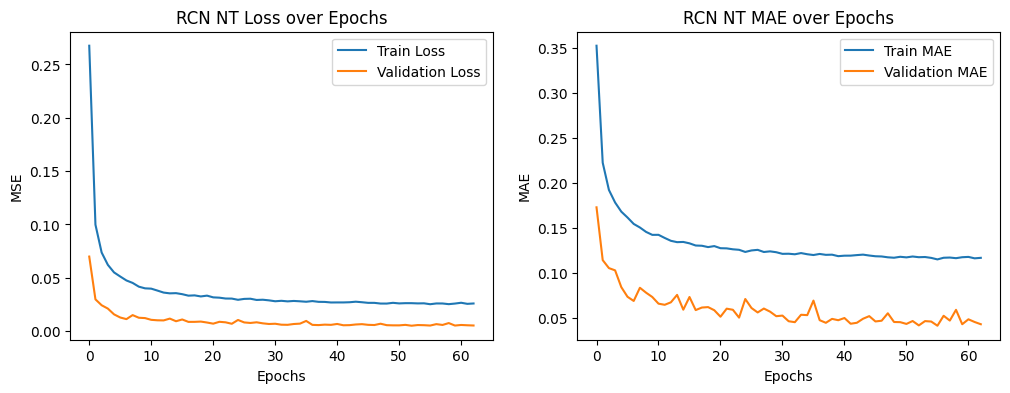

In [16]:
# ======================================
# 6. Plot training history
# ======================================
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('RCN NT Loss over Epochs')

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('RCN NT MAE over Epochs')

plt.show()

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


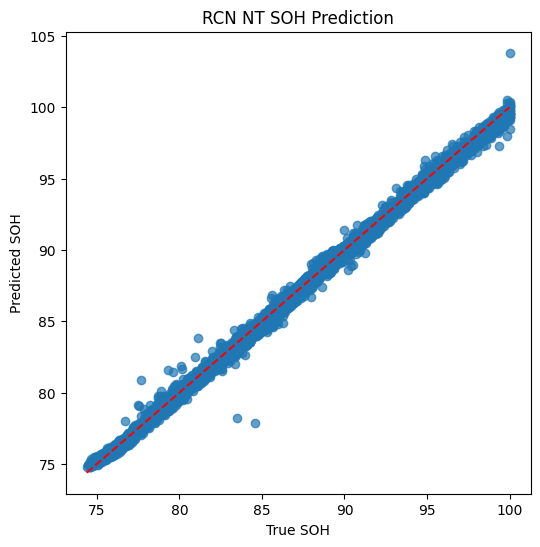

In [11]:
import matplotlib.pyplot as plt

y_pred_norm = model_rcn.predict([X_ic_test, X_context_test]).flatten()

y_pred = y_pred_norm * y_std + y_mean
y_test = y_test_norm * y_std + y_mean

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True SOH")
plt.ylabel("Predicted SOH")
plt.title("RCN NT SOH Prediction")
plt.show()

In [7]:
rcn = keras.models.load_model(r'../../Models/RCN_NT.keras')

In [8]:
from utils.data_split import temp_based_split

data = temp_based_split(X_ic_test, X_context_test, y_test_norm)

-----25 degree Celsius-----
X_ic shape: (1162, 20, 1)
X_context shape: (1162, 7)
y_test shape: (1162,) 

-----35 degree Celsius-----
X_ic shape: (235, 20, 1)
X_context shape: (235, 7)
y_test shape: (235,) 

-----45 degree Celsius-----
X_ic shape: (3131, 20, 1)
X_context shape: (3131, 7)
y_test shape: (3131,) 



In [9]:
from utils.predict import make_predictions

predicitons, true, metrics = make_predictions(rcn, data, y_mean, y_std)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


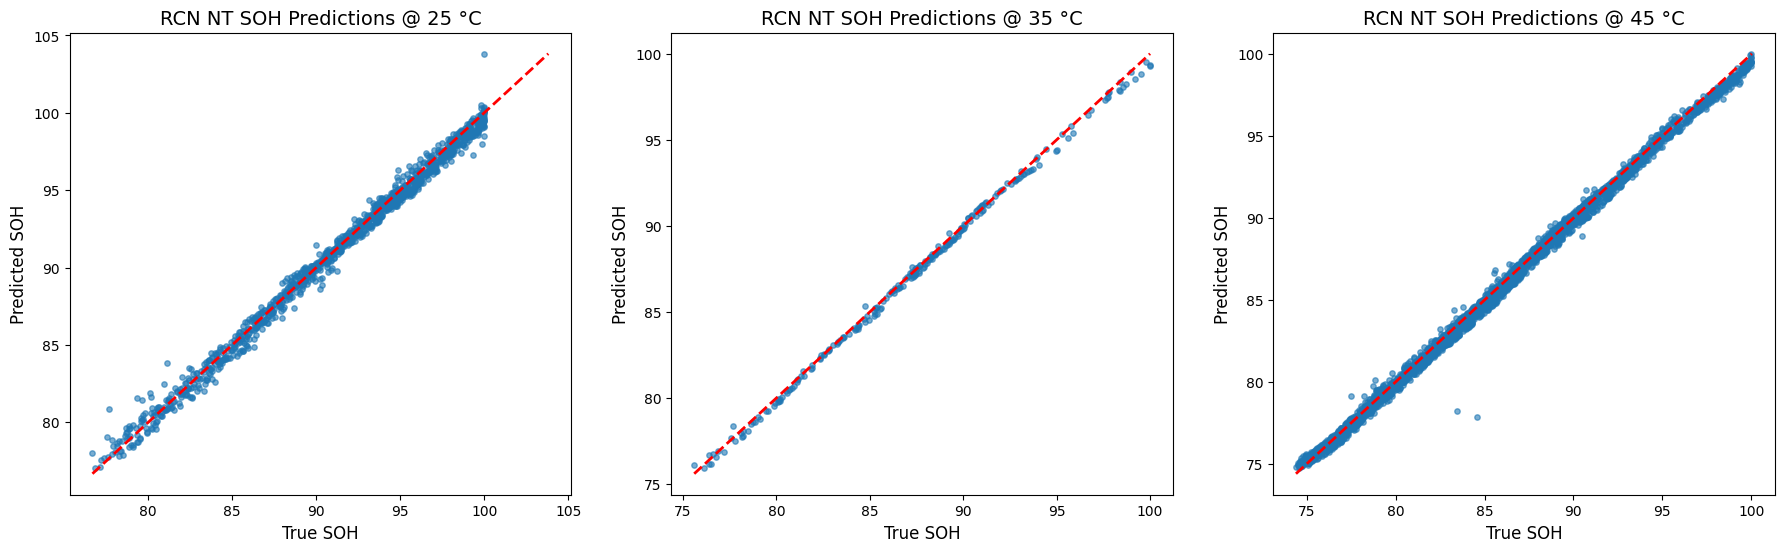

In [10]:
from utils.plots import scatter_plot

scatter_plot(predicitons, true, y_std, y_mean, model_name="RCN NT")

In [11]:
from utils.metrics import get_metrics, format_metrics

metrics = get_metrics(predicitons, true, y_mean, y_std)

format_metrics(metrics, model_name="RCN NT")


RCN NT Metrics - NORMALIZED

+---------------+----------+----------+----------+------------+
| Temperature   |      MAE |      MSE |     RMSE |   R2 Score |
+===============+==========+==========+==========+============+
| 25            | 0.058363 | 0.005934 | 0.077032 |   0.992556 |
+---------------+----------+----------+----------+------------+
| 35            | 0.028315 | 0.00131  | 0.036198 |   0.998185 |
+---------------+----------+----------+----------+------------+
| 45            | 0.03604  | 0.002672 | 0.05169  |   0.996998 |
+---------------+----------+----------+----------+------------+
| complete      | 0.041368 | 0.003438 | 0.058637 |   0.996571 |
+---------------+----------+----------+----------+------------+


RCN NT Metrics - ORIGINAL

+---------------+----------+----------+----------+------------+
| Temperature   |      MAE |      MSE |     RMSE |   R2 Score |
+===============+==========+==========+==========+============+
| 25            | 0.387988 | 0.262242 | 0.077